## Lesson-01 Assignment

#### 今天是2020年1月05日，今天世界上又多了一名AI工程师 :) 

`各位同学大家好，欢迎各位开始学习我们的人工智能课程。这门课程假设大家不具备机器学习和人工智能的知识，但是希望大家具备初级的Python编程能力。根据往期同学的实际反馈，我们课程的完结之后 能力能够超过80%的计算机人工智能/深度学习方向的硕士生的能力。`

## 本次作业的内容

#### 1. 复现课堂代码

在本部分，你需要参照我们给大家的GitHub地址里边的课堂代码，结合课堂内容，复现内容。

---

我们的目标是写一个数据驱动的程序，即使输入的数据发生了改变，程序能自适应而无需重写。Generalization

In [1]:
import random
other_grammar = """
sentence => noun_phrase verb_phrase
noun_phrase => Article Adj* noun
Adj* => null | Adj Adj*
verb_phrase => verb noun_phrase
Article =>  一个 | 那个
noun =>   超人 |  蝙蝠侠 | 黑寡妇 | 绿巨人
verb => 追着   |  锤了 |  击飞 | 碾压
Adj =>  疯狂的 | 性感的 | 弱小的
"""

生成结构化的语法

In [2]:
def create_grammar(grammar_str, split='=>', line_split='\n'):
    grammar = {}
    for line in grammar_str.split(line_split):
        if not line.strip(): 
            continue
        exp, stmt = line.split(split)
        grammar[exp.strip()] = [s.split() for s in stmt.split('|')]
    return grammar

In [3]:
grammar = create_grammar(other_grammar)

In [4]:
grammar

{'sentence': [['noun_phrase', 'verb_phrase']],
 'noun_phrase': [['Article', 'Adj*', 'noun']],
 'Adj*': [['null'], ['Adj', 'Adj*']],
 'verb_phrase': [['verb', 'noun_phrase']],
 'Article': [['一个'], ['那个']],
 'noun': [['超人'], ['蝙蝠侠'], ['黑寡妇'], ['绿巨人']],
 'verb': [['追着'], ['锤了'], ['击飞'], ['碾压']],
 'Adj': [['疯狂的'], ['性感的'], ['弱小的']]}

按照结构化的语法生成一个句子(递归思想)

In [5]:
def generate(gram, target):
    if target not in gram:
        return target
    expand = [generate(gram,t) for t in random.choice(gram[target])]
    return "".join(e if e != '/n' else '\n' for e in expand if e!='null')

In [6]:
generate(grammar,target='sentence')

'一个蝙蝠侠锤了那个疯狂的性感的超人'

In [7]:
generate(grammar,target='noun_phrase')

'一个蝙蝠侠'

In [8]:
generate(grammar,target='verb_phrase')

'碾压一个蝙蝠侠'

生成多条句子

In [9]:
for i in range(15):
    print(generate(grammar,target='sentence'))

一个黑寡妇击飞那个性感的疯狂的疯狂的黑寡妇
一个性感的性感的超人锤了那个弱小的疯狂的超人
一个弱小的蝙蝠侠击飞一个弱小的性感的性感的弱小的疯狂的疯狂的超人
那个性感的性感的性感的疯狂的蝙蝠侠碾压那个疯狂的黑寡妇
那个黑寡妇击飞一个弱小的超人
那个性感的弱小的性感的性感的性感的超人击飞一个疯狂的弱小的超人
那个弱小的弱小的绿巨人追着一个蝙蝠侠
一个弱小的性感的超人击飞一个黑寡妇
一个疯狂的性感的蝙蝠侠碾压一个弱小的蝙蝠侠
一个性感的疯狂的黑寡妇追着那个弱小的疯狂的超人
那个蝙蝠侠击飞那个弱小的弱小的超人
那个性感的绿巨人追着那个性感的弱小的超人
一个性感的弱小的性感的黑寡妇击飞一个超人
一个超人击飞那个绿巨人
那个弱小的黑寡妇锤了一个黑寡妇


### 使用2-gram语言模型通过词与词之间出现的概率来表征句子的正确性

In [10]:
import numpy as np
import pandas as pd
import random
import os
import re
from collections import Counter
import jieba
from functools import reduce
from operator import add, mul
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
table_path = os.path.join(os.getcwd(),'datasets','sqlResult_1558435.csv')
df_news = pd.read_csv(table_path, encoding='gb18030')

In [12]:
df_news.head()

,id,author,source,content,feature,title,url
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm
2,89615,NaN,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""18""...",一加手机5细节曝光：3300mAh、充半小时用1天,http://www.cnbeta.com/articles/tech/623601.htm
3,89614,NaN,新华社,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n,"{""type"":""国际新闻"",""site"":""环球"",""commentNum"":""0"",""j...",葡森林火灾造成至少62人死亡 政府宣布进入紧急状态（组图）,http://world.huanqiu.com/hot/2017-06/10866126....
4,89613,胡淑丽_MN7479,深圳大件事,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...,"{""type"":""新闻"",""site"":""网易热门"",""commentNum"":""978"",...",44岁女子约网友被拒暴雨中裸奔 交警为其披衣相随,http://news.163.com/17/0618/00/CN617P3Q0001875...


In [13]:
lst_content = df_news['content'].tolist()
len(lst_content)

89611

In [14]:
def token(string):
    return re.findall('\w+', string)

In [15]:
with_jieba_cut = Counter(jieba.cut(lst_content[110]))

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\QIUHQ~1.1\AppData\Local\Temp\13\jieba.cache
Loading model cost 1.609 seconds.
Prefix dict has been built succesfully.


In [16]:
with_jieba_cut.most_common(10)
#统计分词之后的词频

[('，', 88),
 ('的', 73),
 ('。', 39),
 ('\r\n', 27),
 ('了', 20),
 ('们', 18),
 ('工作队', 16),
 ('村民', 15),
 ('收割', 14),
 ('、', 12)]

In [17]:
''.join(token(lst_content[10]))

'证券时报网wwwstcncom06月23日讯据上证报道6月初以来创业板指数明显强于上证综指一时间关于蓝筹行情将向成长股行情切换的预期再起但多位私募人士表示蓝筹股与成长股这两年并非绝对的此消彼长本轮蓝筹股上涨行情的主要推动力就是业绩成长而业绩与估值匹配才是王道上述私募人士依然看好成长性突出的蓝筹股'

In [18]:
content_clean = [''.join(token(str(c))) for c in lst_content]

In [19]:
len(content_clean)

89611

In [20]:
content_clean[1]

'骁龙835作为唯一通过Windows10桌面平台认证的ARM处理器高通强调不会因为只考虑性能而去屏蔽掉小核心相反他们正联手微软找到一种适合桌面平台的兼顾性能和功耗的完美方案报道称微软已经拿到了一些新的源码以便Windows10更好地理解biglittle架构资料显示骁龙835作为一款集成了CPUGPU基带蓝牙WiFi的SoC比传统的Wintel方案可以节省至少30的PCB空间按计划今年Q4华硕惠普联想将首发骁龙835Win10电脑预计均是二合一形态的产品当然高通骁龙只是个开始未来也许还能见到三星Exynos联发科华为麒麟小米澎湃等进入Windows10桌面平台'

In [21]:
with open(os.path.join(os.getcwd(),'datasets','homework_content.txt'),'w') as f:
    for c in content_clean:
        f.write(c + '\n')

In [22]:
def cut(string):
    return list(jieba.cut(string))

lst_token = []

for i,line in enumerate(open(os.path.join(os.getcwd(),'datasets','homework_content.txt'))):
    if i % 100 ==0:
        print(i)
    if i>10000:
        break
    lst_token+=cut(line)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [23]:
words_count = Counter(lst_token)

In [24]:
words_count.most_common(50)

[('的', 184244),
 ('在', 47370),
 ('了', 36722),
 ('和', 30809),
 ('是', 30283),
 ('月', 18711),
 ('也', 15995),
 ('年', 15971),
 ('有', 14714),
 ('为', 14448),
 ('等', 14340),
 ('将', 14060),
 ('对', 13074),
 ('与', 12568),
 ('日', 12322),
 ('中', 11117),
 ('中国', 11036),
 ('6', 10477),
 ('上', 10192),
 ('不', 10027),
 ('\n', 10001),
 ('他', 9530),
 ('都', 9447),
 ('发展', 8795),
 ('企业', 8584),
 ('就', 8537),
 ('到', 8338),
 ('市场', 8095),
 ('但', 7729),
 ('这', 7658),
 ('被', 7575),
 ('从', 7513),
 ('并', 7412),
 ('人', 7339),
 ('后', 7084),
 ('公司', 6915),
 ('一个', 6772),
 ('说', 6703),
 ('新', 6467),
 ('表示', 6309),
 ('要', 6276),
 ('还', 6245),
 ('会', 6179),
 ('个', 6176),
 ('我', 6141),
 ('而', 6090),
 ('进行', 5802),
 ('我们', 5742),
 ('记者', 5734),
 ('以', 5615)]

In [25]:
freq = [f for w,f in words_count.most_common(100)]
x=[i for i in range(100)]

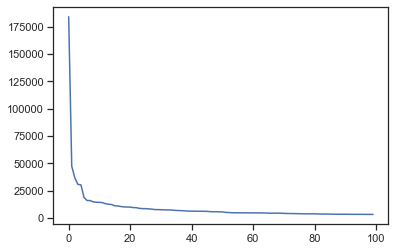

In [26]:
sns.set(style='ticks')
plt.plot(x,freq)

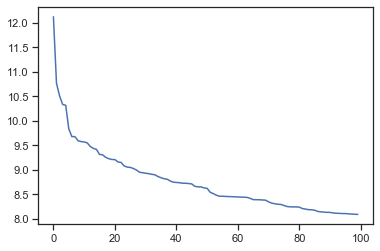

In [27]:
plt.plot(x,np.log(freq))

In [28]:
def prob_1(word):
    return words_count[word] / len(lst_token)

In [29]:
prob_1('你们')

7.959162457875997e-05

In [30]:
lst_token[:10]

['此外', '自', '本周', '6', '月', '12', '日起', '除', '小米', '手机']

In [31]:
lst_token_2_gram = [''.join(lst_token[i:i+2]) for i in range(len(lst_token[:-2]))]

In [32]:
words_count_2 = Counter(lst_token_2_gram)

In [33]:
def prob_2(word1, word2):
    if word1 + word2 in words_count_2: 
        return words_count_2[word1+word2] / len(lst_token_2_gram)
    else:
        return 1 / len(lst_token_2_gram)

In [34]:
prob_2('你们','在')

8.121598742126787e-07

In [35]:
prob_2('去','喝茶')

2.707199580708929e-07

In [36]:
def get_probablity(sentence):
    words = cut(sentence)
    
    sentence_pro = 1
    
    for i, word in enumerate(words[:-1]):
        next_ = words[i+1]
        
        probability = prob_2(word, next_)
        
        sentence_pro *= probability
    
    return sentence_pro

In [37]:
get_probablity('小明今年年会啥也没抽到')

2.9524524231175514e-38

In [38]:
get_probablity('隔壁老王今天突然不回家了')

9.447847753976164e-39

In [39]:
for sen in [generate(grammar,target='sentence') for i in range(10)]:
    print('sentence: {} with Prb: {}'.format(sen, get_probablity(sen)))

sentence: 那个弱小的绿巨人击飞一个性感的弱小的性感的黑寡妇 with Prb: 2.4794951995086783e-76
sentence: 一个超人追着那个性感的弱小的弱小的绿巨人 with Prb: 8.457903626639442e-65
sentence: 那个性感的绿巨人追着一个超人 with Prb: 3.9366032308234e-39
sentence: 那个弱小的性感的蝙蝠侠锤了那个蝙蝠侠 with Prb: 6.248452228575322e-57
sentence: 一个黑寡妇击飞一个绿巨人 with Prb: 5.371320863895103e-27
sentence: 那个绿巨人锤了一个性感的绿巨人 with Prb: 6.181158957223465e-43
sentence: 那个蝙蝠侠追着那个绿巨人 with Prb: 5.371320863895103e-27
sentence: 一个黑寡妇锤了那个超人 with Prb: 1.4541237590589946e-32
sentence: 那个弱小的蝙蝠侠锤了那个疯狂的弱小的性感的绿巨人 with Prb: 1.879496742054315e-81
sentence: 一个蝙蝠侠锤了一个弱小的性感的疯狂的蝙蝠侠 with Prb: 1.1155531991515461e-65


In [40]:
need_compared = [
    "你今天好美啊 你今天啊好美",
    "明天不睡觉 明天睡觉不",
    "开车不喝酒 喝酒不开车",
    "你的益达 不这是益达的你"
]

for s in need_compared:
    s1, s2 = s.split()
    p1, p2 = get_probablity(s1), get_probablity(s2)
    
    better = s1 if p1 > p2 else s2
    
    print('{} is more possible'.format(better))
    print('-'*4 + ' {} with probility {}'.format(s1, p1))
    print('-'*4 + ' {} with probility {}'.format(s2, p2))

你今天好美啊 is more possible
---- 你今天好美啊 with probility 1.3888612540867667e-19
---- 你今天啊好美 with probility 7.519849209453144e-26
明天不睡觉 is more possible
---- 明天不睡觉 with probility 2.93157182791624e-13
---- 明天睡觉不 with probility 7.3289295697906e-14
开车不喝酒 is more possible
---- 开车不喝酒 with probility 2.1986788709371802e-13
---- 喝酒不开车 with probility 7.3289295697906e-14
你的益达 is more possible
---- 你的益达 with probility 2.1913499413673896e-11
---- 不这是益达的你 with probility 1.0382443639681221e-28


#### 2. 作业截止时间
此次作业截止时间为 2020.01.19日

#### 3. 完成以下问答和编程练习

>

## 基础理论部分

> **评阅点**：每道题是否回答完整

#### 0. Can you come up out 3 sceneraies which use AI methods? 

Ans: 语音识别，个性化推荐，聊天机器人

#### 1. How do we use Github; Why do we use Jupyter and Pycharm;

Ans: GitHub用于代码托管和版本控制，Juyter和Pycharm是常用的IDE，用于程序代码的开发

#### 2. What's the Probability Model?

Ans: 概率模型是用来描述不同随机变量之间关系的数学模型,是概率分布函数或密度函数的集合

#### 3. Can you came up with some sceneraies at which we could use Probability Model?

Ans:贝叶斯，逻辑回归，马尔可夫

#### 4. Why do we use probability and what's the difficult points for programming based on parsing and pattern match?

Ans:概率更数学化，更易于计算机运算，基于语法和模型匹配的编程难点在于非结构化和多样性

#### 5. What's the Language Model;

Ans:一个句子的概率，语言抽象数学建模

#### 6. Can you came up with some sceneraies at which we could use Language Model?


Ans: NLP领域

#### 7. What's the 1-gram language model;

Ans:$$P(w_1,w_2...w_m) = \prod_{i=1}^m P(w_i) $$

#### 8. What's the disadvantages and advantages of 1-gram language model;

Ans: 没有考虑词与词之间的关系

#### What't the 2-gram models

*1-gram models: $$P(w_1,w_2...w_m) = \prod_{i=1}^m P(w_i) $$*

*2(Bi)-gram models: 
$$P(w_1,w_2...w_m) = \prod_{i=1}^m P(w_i|w_{i-1}) $$*

*3(Tri)-gram models:$$P(w_1,w_2...w_m) = \prod_{i=1}^m P(w_i|w_{i-2},w_{i-1}) $$*

## 编程实践部分

#### 1. 设计你自己的句子生成器

如何生成句子是一个很经典的问题，从1940s开始，图灵提出机器智能的时候，就使用的是人类能不能流畅和计算机进行对话。和计算机对话的一个前提是，计算机能够生成语言。

计算机如何能生成语言是一个经典但是又很复杂的问题。 我们课程上为大家介绍的是一种基于规则（Rule Based）的生成方法。该方法虽然提出的时间早，但是现在依然在很多地方能够大显身手。值得说明的是，现在很多很实用的算法，都是很久之前提出的，例如，二分查找提出与1940s, Dijstra算法提出于1960s 等等。

在著名的电视剧，电影《西部世界》中，这些机器人们语言生成的方法就是使用的SyntaxTree生成语言的方法。

> 
>

![WstWorld](https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1569578233461&di=4adfa7597fb380e7cc0e67190bbd7605&imgtype=0&src=http%3A%2F%2Fs1.sinaimg.cn%2Flarge%2F006eYYfyzy76cmpG3Yb1f)

> 
>

在这一部分，需要各位同学首先定义自己的语言。 大家可以先想一个应用场景，然后在这个场景下，定义语法。例如：

在西部世界里，一个”人类“的语言可以定义为：
``` 
human = """
human = 自己 寻找 活动
自己 = 我 | 俺 | 我们 
寻找 = 看看 | 找找 | 想找点
活动 = 乐子 | 玩的
"""
```

一个“接待员”的语言可以定义为
```
host = """
host = 寒暄 报数 询问 业务相关 结尾 
报数 = 我是 数字 号 ,
数字 = 单个数字 | 数字 单个数字 
单个数字 = 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 
寒暄 = 称谓 打招呼 | 打招呼
称谓 = 人称 ,
人称 = 先生 | 女士 | 小朋友
打招呼 = 你好 | 您好 
询问 = 请问你要 | 您需要
业务相关 = 玩玩 具体业务
玩玩 = 耍一耍 | 玩一玩
具体业务 = 喝酒 | 打牌 | 打猎 | 赌博
结尾 = 吗？"""

```




请定义你自己的语法: 

第一个语法：

In [41]:
customer = '''
customer => 人物 意愿 物品
人物 => 我 | 我们 | 大伙儿
意愿 => 想要 | 缺点儿 | 寻思着 
物品 => 吃的 | 喝的 | 玩的 | 乐子
'''


> **评阅点**： 是否提出了和课程上区别较大的语法结构

第二个语法：

In [42]:
host = '''
host => 寒暄 自我介绍 询问 业务 结尾
寒暄 => 人称 打招呼
人称 => 帅哥 | 美女 | 小朋友
打招呼 => 你好， | 您好， 
自我介绍 => 我是 工号 号，
工号 => 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 
询问 => 请问你要 | 您需要
业务 => 中国菜 | 哈啤 | 打桌球 | 音乐
结尾 => 吗？
'''

> **评阅点**：是否和上一个语法区别比较大

TODO: 然后，使用自己之前定义的generate函数，使用此函数生成句子。

TODO: 然后，定义一个函数，generate_n，将generate扩展，使其能够生成n个句子:

In [43]:
def generate_n(gram,target,n):
    c_gram = create_grammar(gram)
    for i in range(n):
        print(generate(c_gram,target))

In [44]:
generate_n(host,'host',10)

帅哥你好，我是8号，请问你要打桌球吗？
帅哥您好，我是6号，请问你要打桌球吗？
帅哥你好，我是1号，请问你要哈啤吗？
小朋友你好，我是1号，您需要音乐吗？
美女你好，我是3号，您需要音乐吗？
帅哥您好，我是6号，请问你要哈啤吗？
美女您好，我是9号，您需要中国菜吗？
小朋友你好，我是6号，您需要音乐吗？
小朋友您好，我是8号，您需要中国菜吗？
帅哥您好，我是5号，请问你要打桌球吗？


> **评阅点**; 运行代码，观察是否能够生成多个句子

#### 2. 使用新数据源完成语言模型的训练

按照我们上文中定义的`prob_2`函数，我们更换一个文本数据源，获得新的Language Model:

1. 下载文本数据集（你可以在以下数据集中任选一个，也可以两个都使用）
    + 可选数据集1，保险行业问询对话集： https://github.com/Computing-Intelligence/insuranceqa-corpus-zh/raw/release/corpus/pool/train.txt.gz
    + 可选数据集2：豆瓣评论数据集：https://github.com/Computing-Intelligence/datasource/raw/master/movie_comments.csv
2. 修改代码，获得新的**2-gram**语言模型
    + 进行文本清洗，获得所有的纯文本
    + 将这些文本进行切词
    + 送入之前定义的语言模型中，判断文本的合理程度

In [45]:
import os
import gzip
import pandas as pd
import numpy as np
import re

## insurance data

In [46]:
text_path = os.path.join(os.getcwd(),'datasets','train.txt.gz')
with gzip.open(text_path,'r') as pf:
    df_dialog = pf.read().decode('utf-8')

In [47]:
df_dialog[:1000]

'0 ++$++ disability-insurance ++$++ 法律要求残疾保险吗？ ++$++ Is  Disability  Insurance  Required  By  Law?\n1 ++$++ life-insurance ++$++ 债权人可以在死后人寿保险吗？ ++$++ Can  Creditors  Take  Life  Insurance  After  Death?\n2 ++$++ renters-insurance ++$++ 旅行者保险有租赁保险吗？ ++$++ Does  Travelers  Insurance  Have  Renters  Insurance?\n3 ++$++ auto-insurance ++$++ 我可以开一辆没有保险的新车吗？ ++$++ Can  I  Drive  A  New  Car  Home  Without  Insurance?\n4 ++$++ life-insurance ++$++ 人寿保险的现金转出价值是否应纳税？ ++$++ Is  The  Cash  Surrender  Value  Of  Life  Insurance  Taxable?\n5 ++$++ annuities ++$++ 如何报告年金收入？ ++$++ How  Is  Annuity  Income  Reported?\n6 ++$++ home-insurance ++$++ AAA家庭保险涵盖什么？ ++$++ What  Does  AAA  Home  Insurance  Cover?\n7 ++$++ retirement-plans ++$++ 什么是简单的退休计划？ ++$++ What  Is  A  Simple  Retirement  Plan?\n8 ++$++ disability-insurance ++$++ 社会保险残疾保险是什么？ ++$++ What  Does  Social  Security  Disability  Insurance  Cover?\n9 ++$++ auto-insurance ++$++ 汽车保险是否预付？ ++$++ Is  Car  Insurance  Prepaid?\n10 ++$++ medicare-ins

In [48]:
lst_dialog = df_dialog.split('\n')

In [49]:
len(lst_dialog)

12890

In [50]:
lst_dialog[:5]

['0 ++$++ disability-insurance ++$++ 法律要求残疾保险吗？ ++$++ Is  Disability  Insurance  Required  By  Law?',
 '1 ++$++ life-insurance ++$++ 债权人可以在死后人寿保险吗？ ++$++ Can  Creditors  Take  Life  Insurance  After  Death?',
 '2 ++$++ renters-insurance ++$++ 旅行者保险有租赁保险吗？ ++$++ Does  Travelers  Insurance  Have  Renters  Insurance?',
 '3 ++$++ auto-insurance ++$++ 我可以开一辆没有保险的新车吗？ ++$++ Can  I  Drive  A  New  Car  Home  Without  Insurance?',
 '4 ++$++ life-insurance ++$++ 人寿保险的现金转出价值是否应纳税？ ++$++ Is  The  Cash  Surrender  Value  Of  Life  Insurance  Taxable?']

In [51]:
dialog_clean = [''.join(re.findall('[\u4e00-\u9fa5]+',str(d_i))) for d_i in lst_dialog]
len(dialog_clean)

12890

In [52]:
dialog_clean[:5]

['法律要求残疾保险吗',
 '债权人可以在死后人寿保险吗',
 '旅行者保险有租赁保险吗',
 '我可以开一辆没有保险的新车吗',
 '人寿保险的现金转出价值是否应纳税']

## douban data

In [53]:
csv_path = os.path.join(os.getcwd(),'datasets','movie_comments.csv')
df_comments = pd.read_csv(csv_path,encoding='utf-8',header=0,sep=',',low_memory=False)

In [54]:
df_comments.head()

,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1


In [55]:
lst_comments = df_comments['comment'].tolist()

In [56]:
len(lst_comments)

261497

In [57]:
lst_comments[:5]

['吴京意淫到了脑残的地步，看了恶心想吐',
 '首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮番上场，视物理逻辑于不顾，不得不说有钱真好，随意胡闹',
 '吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋律，为了煽情而煽情，让人觉得他是个大做作、大谎言家。（7.29更新）片子整体不如湄公河行动，1.整体不够流畅，编剧有毒，台词尴尬；2.刻意做作的主旋律煽情显得如此不合时宜而又多余。',
 '凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。',
 '中二得很']

In [58]:
comments_clean = [''.join(re.findall('[\w]+',str(d_i))) for d_i in lst_comments]
len(comments_clean)

261497

In [59]:
comments_clean[:5]

['吴京意淫到了脑残的地步看了恶心想吐',
 '首映礼看的太恐怖了这个电影不讲道理的完全就是吴京在实现他这个小粉红的英雄梦各种装备轮番上场视物理逻辑于不顾不得不说有钱真好随意胡闹',
 '吴京的炒作水平不输冯小刚但小刚至少不会用主旋律来炒作吴京让人看了不舒服为了主旋律而主旋律为了煽情而煽情让人觉得他是个大做作大谎言家729更新片子整体不如湄公河行动1整体不够流畅编剧有毒台词尴尬2刻意做作的主旋律煽情显得如此不合时宜而又多余',
 '凭良心说好看到不像战狼1的续集完虐湄公河行动',
 '中二得很']

In [60]:
str_clean = dialog_clean + comments_clean
random.shuffle(str_clean)
len(str_clean)

274387

In [61]:
str_clean[:5]

['算比较无聊',
 '我可以随时取消汽车保险吗',
 '上海大龙的插曲笑喷俺作为中国人不习惯那样配音除了LimitCycle其余都很喜欢',
 '人物动物特效还行场景特效要差一些音乐不错去电影院看3d应该更有感觉',
 '人言可畏']

In [62]:
for line in str_clean[:10]:
    print("{} probability: {}".format(line,get_probablity(line)))
    print('-'*20)

算比较无聊 probability: 7.3289295697906e-14
--------------------
我可以随时取消汽车保险吗 probability: 7.197912607342022e-31
--------------------
上海大龙的插曲笑喷俺作为中国人不习惯那样配音除了LimitCycle其余都很喜欢 probability: 2.857987896054851e-115
--------------------
人物动物特效还行场景特效要差一些音乐不错去电影院看3d应该更有感觉 probability: 1.4824090297568627e-121
--------------------
人言可畏 probability: 1
--------------------
白送的票全程玩手机 probability: 1.744948510870793e-31
--------------------
镜头配乐 probability: 2.707199580708929e-07
--------------------
看的粤语版完整版单纯正直的高岗因为一步步深陷黑拳的深渊看的同时不禁想起吴京本人全国冠军出生当他在电影里说出想要像师兄李连杰一样时有一刻仿佛那个单纯少年就是他本人的影子电影结局让人唏嘘却不可避免最后当他俩光着脚坐在星空下的时候多希望当初没有踏入命运的漩涡 probability: 0.0
--------------------
看完我真他妈自卑 probability: 2.57823401466965e-25
--------------------
我下载看杨幂的每部片只是为了能有资本恶心她 probability: 1.4025911742153343e-85
--------------------


> **评阅点** 1. 是否使用了新的数据集； 2. csv(txt)数据是否正确解析

#### 3. 获得最优质的的语言

当我们能够生成随机的语言并且能判断之后，我们就可以生成更加合理的语言了。请定义 generate_best 函数，该函数输入一个语法 + 语言模型，能够生成**n**个句子，并能选择一个最合理的句子: 



提示，要实现这个函数，你需要Python的sorted函数

In [63]:
sorted([1, 3, 5, 2])

[1, 2, 3, 5]

这个函数接受一个参数key，这个参数接受一个函数作为输入，例如

In [64]:
sorted([(2, 5), (1, 4), (5, 0), (4, 4)], key=lambda x: x[0])

[(1, 4), (2, 5), (4, 4), (5, 0)]

能够让list按照第0个元素进行排序.

In [65]:
sorted([(2, 5), (1, 4), (5, 0), (4, 4)], key=lambda x: x[1])

[(5, 0), (1, 4), (4, 4), (2, 5)]

能够让list按照第1个元素进行排序.

In [66]:
sorted([(2, 5), (1, 4), (5, 0), (4, 4)], key=lambda x: x[1], reverse=True)

[(2, 5), (1, 4), (4, 4), (5, 0)]

能够让list按照第1个元素进行排序, 但是是递减的顺序。

>

In [107]:
other_grammar = """
sentence => noun_phrase verb_phrase
noun_phrase => Article Adj* noun
Adj* => null | Adj Adj*
verb_phrase => verb noun_phrase
Article =>  一个 | 那个
noun =>   超人 |  蝙蝠侠 | 黑寡妇 | 绿巨人
verb => 追着   |  锤了 |  击飞 | 碾压
Adj =>  疯狂的 | 性感的 | 弱小的
"""

host = '''
host => 寒暄 自我介绍 询问 业务 结尾
寒暄 => 人称 打招呼
人称 => 帅哥 | 美女 | 小朋友
打招呼 => 你好， | 您好， 
自我介绍 => 我是 工号 号，
工号 => 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 
询问 => 请问你要 | 您需要
业务 => 中国菜 | 哈啤 | 打桌球 | 音乐
结尾 => 吗？
'''

def create_grammer(grammer_str,split='=>',split_line='\n'):
    grammer = {}
    for line in grammer_str.split(split_line):
        if not line.strip():
            continue
        exp,stmt = line.split(split)
        grammer[exp.strip()] = [s.split() for s in stmt.split('|')]
    return grammer
        
def generate(gram,target):
    if target not in gram:
        return target
    expend = [generate(gram,t) for t in random.choice(gram[target])]
    return "".join(e if e!='/n'else'\n' for e in expend if e!='null')

def two_gram_prob(word,next_word,corpus,word_count):
    if word+next_word in corpus:
        return word_count[word+next_word]/len(corpus)
    else:
        return 1/len(corpus)

def get_probability(snt,corpus,word_count):
    lst_word = list(jieba.cut(snt))
    snt_prob = 1
    
    for i,word in enumerate(lst_word[:-1]):
        next_ = lst_word[i+1]   
        word_prob = two_gram_prob(word,next_,corpus,word_count)
        snt_prob*=word_prob
        
    return snt_prob
    
def generate_best(snt_num,grammer,target,corpus,word_count): # you code here
    lst_snt= []
    for i in range(snt_num):
        snt_i = generate(grammer,target)
        snt_prob = get_probability(snt_i,corpus,word_count)
        lst_snt.append(tuple([snt_i,snt_prob]))
    best_snt = sorted(lst_snt,key=lambda x:x[1],reverse=True)[0]
    print('The best sentence is : {} \n its probability : {}'.format(best_snt[0],best_snt[1]))

In [72]:
len(str_clean)

274387

In [73]:
lst_str_token = []
for s in str_clean:    
    lst_str_token+=jieba.cut(s)

lst_str_token_2 = ["".join(lst_str_token[i:i+2]) for i in range(len(lst_str_token)-2)]
str_word_count_2 = Counter(lst_str_token_2)


In [111]:
grammer = create_grammer(other_grammar)
generate_best(10,grammer,'sentence',lst_str_token_2,str_word_count_2)

The best sentence is : 那个疯狂的超人击飞那个超人 
 its probability : 4.232543687422127e-36


In [112]:
grammer = create_grammer(host)
generate_best(10,grammer,'host',lst_str_token_2,str_word_count_2)

The best sentence is : 帅哥您好，我是8号，您需要音乐吗？ 
 its probability : 1.994663966417401e-74


好了，现在我们实现了自己的第一个AI模型，这个模型能够生成比较接近于人类的语言。

> **评阅点**： 是否使用 lambda 语法进行排序

Q: 这个模型有什么问题？ 你准备如何提升？ 

Ans:我用课程给的数据作为base重新定义了模型，并且能通过输入词库而解决OOV问题

缺点：只定义了2-gram，无法解决3-gram问题

如何提升：通过输入参数n来决定使用n-gram model

>**评阅点**: 是否提出了比较实际的问题，例如OOV问题，例如数据量，例如变成 3-gram问题。

##### 以下内容为可选部分，对于绝大多数同学，能完成以上的项目已经很优秀了，下边的内容如果你还有精力可以试试，但不是必须的。

#### 4. (Optional) 完成基于Pattern Match的语句问答
> 我们的GitHub仓库中，有一个assignment-01-optional-pattern-match，这个难度较大，感兴趣的同学可以挑战一下。


#### 5. (Optional) 完成阿兰图灵机器智能原始论文的阅读
1. 请阅读阿兰图灵关于机器智能的原始论文：https://github.com/Computing-Intelligence/References/blob/master/AI%20%26%20Machine%20Learning/Computer%20Machinery%20and%20Intelligence.pdf 
2. 并按照GitHub仓库中的论文阅读模板，填写完毕后发送给我: mqgao@kaikeba.com 谢谢

> 

各位同学，我们已经完成了自己的第一个AI模型，大家对人工智能可能已经有了一些感觉，人工智能的核心就是，我们如何设计一个模型、程序，在外部的输入变化的时候，我们的程序不变，依然能够解决问题。人工智能是一个很大的领域，目前大家所熟知的深度学习只是其中一小部分，之后也肯定会有更多的方法提出来，但是大家知道人工智能的目标，就知道了之后进步的方向。

然后，希望大家对AI不要有恐惧感，这个并不难，大家加油！

>

![](https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1561828422005&di=48d19c16afb6acc9180183a6116088ac&imgtype=0&src=http%3A%2F%2Fb-ssl.duitang.com%2Fuploads%2Fitem%2F201807%2F28%2F20180728150843_BECNF.thumb.224_0.jpeg)